In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [163]:
dataset = pd.read_csv("./data/labelled_dataset.csv")
dataset.drop(columns=["score", "sentiment_score", "sentiment_by_score"], inplace=True)
dataset.rename(columns={"content":"sequence", "sentiment_by_content": "label"}, inplace=True)
dataset.label.replace({"positive": 1, "negative": 0, "neutral": 2}, inplace=True)
dataset = dataset.loc[dataset.sequence.str.split().str.len() >= 3]
print(dataset.shape)
dataset.head(5)

(1227, 2)


C:\Users\Bugi\AppData\Local\Temp\ipykernel_8484\1681060734.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset.label.replace({"positive": 1, "negative": 0, "neutral": 2}, inplace=True)
C:\Users\Bugi\AppData\Local\Temp\ipykernel_8484\1681060734.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)

,sequence,label
1,halte lengkap tanda bus trans metro deli kompl...,0
2,datang posisi tinggal puter cileunyi,0
3,hallo kota manado sulawesi utara teman bus mak...,1
4,tolong dishub sedia rute akomodasi teman bus j...,0
5,aplikasi mbantu banget gatau udah top lengkap ...,0


In [164]:
sequences_train, sequences_test, labels_train, labels_test = train_test_split(dataset.sequence, dataset.label, test_size=0.2, random_state=1915, stratify=dataset.label)

In [165]:
labels_train_final = np.array(labels_train)
labels_test_final = np.array(labels_test)

In [166]:
vocab_size = 10000
embedding_dim = 150
max_length = 100
trunch_type = "post"
oov_tok = "<OOV>"

In [167]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sequences_train)
word_index = tokenizer.word_index

In [168]:
train_sequences = tokenizer.texts_to_sequences(sequences_train)
training_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunch_type)
testing_sequences = tokenizer.texts_to_sequences(sequences_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [169]:
ranforent = RandomForestClassifier()
logistic = LogisticRegression()
decisiontree = DecisionTreeClassifier()

In [170]:
print(f"Start training logistic regression")
ranforent.fit(training_padded, labels_train_final)
print(f"Random Forest Classifier: {accuracy_score(labels_test_final, ranforent.predict(testing_padded))}")

print(f"Start training logistic regression")
logistic.fit(training_padded, labels_train_final)
print(f"Logistic Regression: {accuracy_score(labels_test_final, logistic.predict(testing_padded))}")

print(f"Start training decision tree")
decisiontree.fit(training_padded, labels_train_final)
print(f"Decision Tree Classifier: {accuracy_score(labels_test_final, decisiontree.predict(testing_padded))}")

Start training logistic regression
Random Forest Classifier: 0.7926829268292683
Start training logistic regression
Logistic Regression: 0.7642276422764228
Start training decision tree
Decision Tree Classifier: 0.6910569105691057


c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [174]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(3, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0004), metrics=["accuracy"])

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") > 0.84:
            print("\nReached 84% accuracy so cancelling training!")
            self.model.stop_training = True

history = model.fit(
    training_padded,
    labels_train_final,
    epochs=100,
    validation_data=(testing_padded, labels_test_final),
    callbacks=[myCallback()]
)

Epoch 1/100
31/31 [==============================] - 21s 186ms/step - loss: 1.5641 - accuracy: 0.4108 - val_loss: 1.0947 - val_accuracy: 0.7846
Epoch 2/100
31/31 [==============================] - 4s 135ms/step - loss: 1.3467 - accuracy: 0.4771 - val_loss: 1.0642 - val_accuracy: 0.7846
Epoch 3/100
31/31 [==============================] - 4s 138ms/step - loss: 1.1259 - accuracy: 0.5382 - val_loss: 1.0380 - val_accuracy: 0.7846
Epoch 4/100
31/31 [==============================] - 5s 149ms/step - loss: 1.1134 - accuracy: 0.5423 - val_loss: 1.0364 - val_accuracy: 0.7846
Epoch 5/100
31/31 [==============================] - 5s 149ms/step - loss: 1.0172 - accuracy: 0.6116 - val_loss: 1.0249 - val_accuracy: 0.7846
Epoch 6/100
31/31 [==============================] - 4s 140ms/step - loss: 0.9669 - accuracy: 0.6239 - val_loss: 0.9988 - val_accuracy: 0.7846
Epoch 7/100
31/31 [==============================] - 5s 153ms/step - loss: 0.8769 - accuracy: 0.6483 - val_loss: 0.9807 - val_accuracy: 0.784

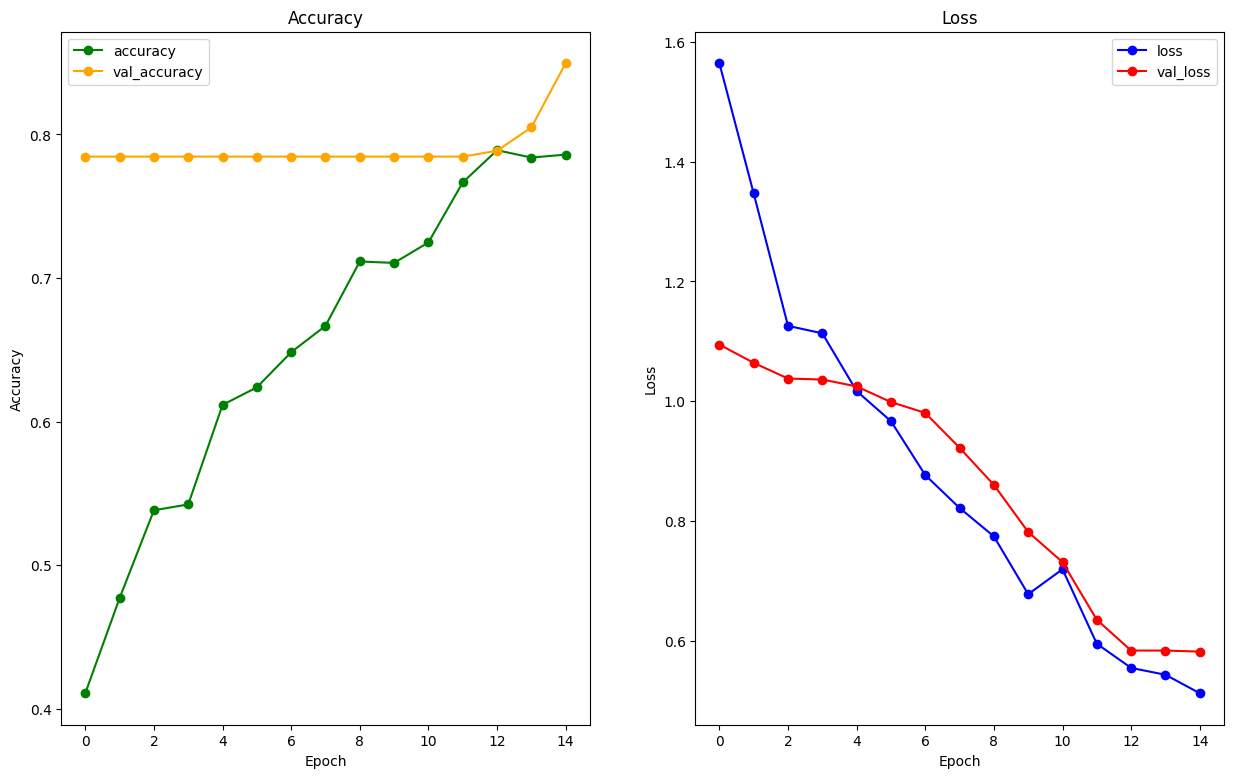

In [175]:
plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy", color="green", marker="o")
plt.plot(history.history["val_accuracy"], label="val_accuracy", color="orange", marker="o")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss", color="blue", marker="o")
plt.plot(history.history["val_loss"], label="val_loss", color="red", marker="o")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [176]:
model.save("./models/sentiment_model.h5")

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
